<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/topic_6_transfer_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Study from Conspect information

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# Enables the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
# Effective when input sizes for the network do not vary.
cudnn.benchmark = True

plt.ion()   # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

Опишемо навчальну й тестову аугментації.

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Створимо клас Dataset.

In [3]:
data_dir = '/content/drive/MyDrive/DeepLearningforComputervisionandNLP/Module_3_Topic_6_hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

Створимо клас DataLoader.

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

Збережемо інформацію про розмір датасету та назви класів.

In [5]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 244, 'val': 153}
['ants', 'bees']


Створимо функцію для відображення прикладів.

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # Imagenet mean
    std = np.array([0.229, 0.224, 0.225]) # Imagenet std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Візуалізуємо один батч даних.

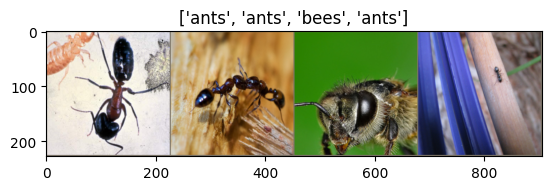

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Напишемо загальну функцію train_model, яка буде виконувати навчання й валідацію моделі протягом num_epochs. Кінцевим результатом роботи функції буде модель, що показала найвищу точність на валідації.

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

				# save model
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Також створимо функцію для візуалізації результатів.

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# ***Навчання всіх ваг моделі***

Завантажимо претреновані ваги моделі ResNet.
У параметрі weights зазначимо посилання на набір даних ImageNet.

In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


Нам потрібно встановити останній fully-connected шар лінійним шаром, який на виході матиме кількість нейронів, рівну кількості класів моделі.

In [11]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)


Переведемо модель на доступний обчислювальний пристрій — CPU або GPU.

In [12]:
model_ft = model_ft.to(device)


*функцією втрат буде CrossEntropyLoss.*

In [13]:
criterion = nn.CrossEntropyLoss()


***У якості алгоритму оптимізації вистачить SGD.*** ???????? чому далі вказано Adam

In [14]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)


# Зменшення learning rate кожні 2 епох у 10 разів

In [15]:
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.001)

# Експоненціальне зменшення learning rate

In [18]:
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.9)

Виконаємо навчання моделі протягом 5 епох. Результати тренування надрукуємо в консоль.

Для lr_scheduler.StepLR

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)


Epoch 1/5
----------
train Loss: 0.4119 Acc: 0.8033
val Loss: 0.2270 Acc: 0.9346

Epoch 2/5
----------
train Loss: 0.3132 Acc: 0.8689
val Loss: 0.1792 Acc: 0.9542

Epoch 3/5
----------
train Loss: 0.3064 Acc: 0.8730
val Loss: 0.1826 Acc: 0.9477

Epoch 4/5
----------
train Loss: 0.3431 Acc: 0.8115
val Loss: 0.2111 Acc: 0.9216

Epoch 5/5
----------
train Loss: 0.3390 Acc: 0.8525
val Loss: 0.1956 Acc: 0.9346

Training complete in 0m 21s
Best val Acc: 0.954248


# ***Навчання тільки класифікаційного шару***

Тепер виконаємо тренування тільки класифікаційного шару. Усі інші ваги моделі будуть «заморожені» (frozen) — тобто для ваг цих шарів ми не будемо розраховувати градієнти й виконувати процедуру оновлення ваг.

***Для початку знову завантажимо модель ResNet18, претреновану на датасеті ImageNet.***

In [20]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')


***Тепер для всіх параметрів моделі встановимо параметр requires_grad = False ***

In [21]:
for param in model_conv.parameters():
    param.requires_grad = False


Тепер додамо класифікаційний шар. Параметри новостворених шарів за замовчуванням мають requires_grad = True.

In [22]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)


In [23]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-03)


# Експоненціальне зменшення learning rate



In [28]:
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_conv, gamma=0.9)

Повторимо тренування моделі.

In [29]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)


Epoch 1/5
----------
train Loss: 0.3970 Acc: 0.8115
val Loss: 0.1634 Acc: 0.9542

Epoch 2/5
----------
train Loss: 0.3522 Acc: 0.8361
val Loss: 0.1796 Acc: 0.9542

Epoch 3/5
----------
train Loss: 0.3142 Acc: 0.8607
val Loss: 0.1650 Acc: 0.9542

Epoch 4/5
----------
train Loss: 0.3498 Acc: 0.8484
val Loss: 0.1915 Acc: 0.9346

Epoch 5/5
----------
train Loss: 0.4068 Acc: 0.8238
val Loss: 0.2363 Acc: 0.8954

Training complete in 0m 19s
Best val Acc: 0.954248
